In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [3]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def select_top_ranks(df, rank = 5): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        top_rank_rows = df.copy().nlargest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df


## Data summary
 

In [6]:
reads_nopDNA = pd.read_csv('../../../Data/Reads/Goujon/Caco2/SecondaryScreens/counts-JD_GPP2845_Goujon_Plate3_CP1658.txt', sep='\t')
reads_nopDNA = reads_nopDNA.copy().drop('Construct IDs', axis=1)
CP1658_cols = ['Construct Barcode']+[col for col in reads_nopDNA.columns if 'CP1658' in col]
reads_nopDNA_CP1658 = reads_nopDNA[CP1658_cols]

pDNA_reads_all = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Secondary_Library/counts-LS20210325_A02_AAHG04_RDA118_G0_CP1658_M-AM33.txt', sep='\t')
pDNA_reads = pDNA_reads_all[['Construct Barcode','A02_AAHG04_RDA118_G0_CP1658_M-AM33']].copy()
pDNA_reads = pDNA_reads.rename(columns = {'A02_AAHG04_RDA118_G0_CP1658_M-AM33': 'pDNA'})
pDNA_reads

reads_CP1658 = pd.merge(pDNA_reads, reads_nopDNA_CP1658, how = 'right', on='Construct Barcode')
empty_cols = [col for col in reads_CP1658.columns if 'EMPTY' in col]
reads_CP1658 = reads_CP1658.copy().drop(empty_cols, axis=1)
reads_CP1658



,Construct Barcode,pDNA,Caco2-CP1658-initial population screen #1,Caco2-CP1658-resistant population screen #1,Caco2-CP1658-initial population screen #2,Caco2-CP1658-resistant population screen #2
0,AAAAAAAATCTTGCTCAGGG,80,3295,3133,4850,5269
1,AAAAAATCGAACCATCTGAA,58,1854,1856,3281,1448
2,AAAAAGCACTACCGTACCAT,51,1690,4283,2099,1236
3,AAAAATCCTCTGAAGCCGCA,67,1472,121,3611,641
4,AAAAATTGTAGGGCGCACCA,61,316,2,986,76
...,...,...,...,...,...,...
6079,TTTGTCACTAAAGTGGACAA,66,2036,1924,2320,1472
6080,TTTGTCCCTTCTTAAAAAAC,30,2388,2974,2179,1760
6081,TTTGTCGTGAAGATGCACAA,65,4333,4635,3620,3309
6082,TTTGTGCTCACCTACAAGCT,31,1531,1340,1572,622


In [9]:
# Gene Annotations
chip = pd.read_csv('../../../Data/Interim/Goujon/Secondary_Library/CP1658_GRCh38_NCBI_strict_gene_20210604.chip', sep='\t')
chip = chip.rename(columns={'Barcode Sequence':'Construct Barcode'})
chip_reads_CP1658 = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads_CP1658, on = ['Construct Barcode'], how = 'right')
chip_reads_CP1658


,Construct Barcode,Gene Symbol,pDNA,Caco2-CP1658-initial population screen #1,Caco2-CP1658-resistant population screen #1,Caco2-CP1658-initial population screen #2,Caco2-CP1658-resistant population screen #2
0,AAAAAAAATCTTGCTCAGGG,HYMAI,80,3295,3133,4850,5269
1,AAAAAATCGAACCATCTGAA,USP14,58,1854,1856,3281,1448
2,AAAAAGCACTACCGTACCAT,SLC26A7,51,1690,4283,2099,1236
3,AAAAATCCTCTGAAGCCGCA,TOP3A,67,1472,121,3611,641
4,AAAAATTGTAGGGCGCACCA,NCAPG,61,316,2,986,76
...,...,...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN,30,2388,2974,2179,1760
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6,30,2388,2974,2179,1760
6279,TTTGTCGTGAAGATGCACAA,CREBBP,65,4333,4635,3620,3309
6280,TTTGTGCTCACCTACAAGCT,MFSD3,31,1531,1340,1572,622


In [10]:
#Calculate lognorm
cols = chip_reads_CP1658.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads_CP1658.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Caco2-CP1658-initial population screen #1_lognorm,Caco2-CP1658-resistant population screen #1_lognorm,Caco2-CP1658-initial population screen #2_lognorm,Caco2-CP1658-resistant population screen #2_lognorm
0,AAAAAAAATCTTGCTCAGGG,HYMAI,7.727405,7.384351,7.451340,7.958849,8.391646
1,AAAAAATCGAACCATCTGAA,USP14,7.266038,6.561409,6.701652,7.397770,6.539470
2,AAAAAGCACTACCGTACCAT,SLC26A7,7.081768,6.429273,7.900201,6.758146,6.313745
3,AAAAATCCTCTGAAGCCGCA,TOP3A,7.472887,6.232505,2.948728,7.535251,5.383199
4,AAAAATTGTAGGGCGCACCA,NCAPG,7.338333,4.081259,0.151970,5.683071,2.543442
...,...,...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN,6.323669,6.923151,7.376640,6.811621,6.818231
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6,6.323669,6.923151,7.376640,6.811621,6.818231
6279,TTTGTCGTGAAGATGCACAA,CREBBP,7.429415,7.777369,8.013690,7.538823,7.723054
6280,TTTGTGCTCACCTACAAGCT,MFSD3,6.370394,6.288462,6.237016,6.345507,5.340845


## Quality Control
### Population Distributions

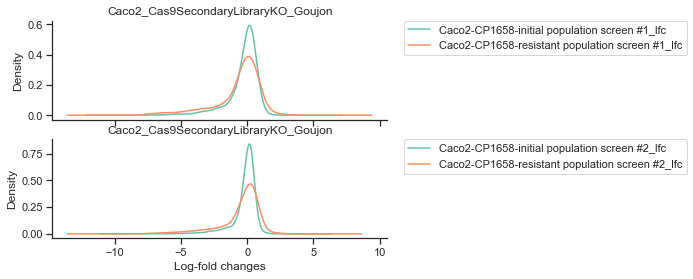

In [11]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[-2:])
paired_cols = (True, [pair1, pair2])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'Caco2_Cas9SecondaryLibraryKO_Goujon')


### Distributions of control sets 

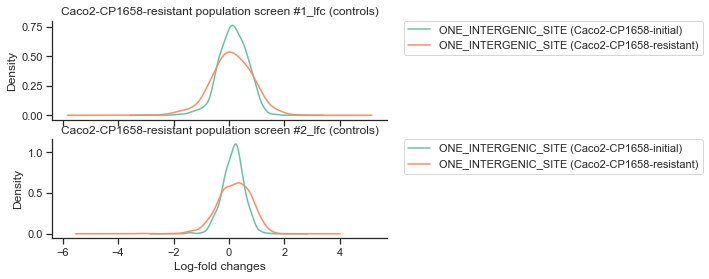

In [12]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'Caco2_Cas9SecondaryLibraryKO_Goujon')


In [13]:
# Get controls
# control_df = fns.get_controls(pDNA_lfc, control_name=['ONE_INTERGENIC_SITE'])
# control_df
# # Screen #1 control vs test 
# fig, axs = plt.subplots(nrows=2, ncols = 1, sharex= True, figsize=(6, 4))
# s = sns.kdeplot(data = pDNA_lfc['Calu3-CP1658-resistant population screen #1_lfc'], ax = axs[0], legend=False)
# s = sns.kdeplot(data = control_df['Calu3-CP1658-resistant population screen #1_lfc'], ax = axs[1])
# axs[1].legend(bbox_to_anchor=(1.05, 1.05), loc=2, borderaxespad=0.)    

# screen1_fifth_percentile = pDNA_lfc['Calu3-CP1658-resistant population screen #1_lfc'].quantile(0.05)
# screen1_95th_percentile = pDNA_lfc['Calu3-CP1658-resistant population screen #1_lfc'].quantile(0.95)
# axs[0].axvline(screen1_fifth_percentile, linestyle = '--', color = 'k')
# axs[1].axvline(screen1_fifth_percentile, linestyle = '--', color = 'k')
# axs[0].axvline(screen1_95th_percentile, linestyle = '--', color = 'k')
# axs[1].axvline(screen1_95th_percentile, linestyle = '--', color = 'k')




### ROC_AUC

Text(0, 0.5, 'True Positive Rate (essential)')

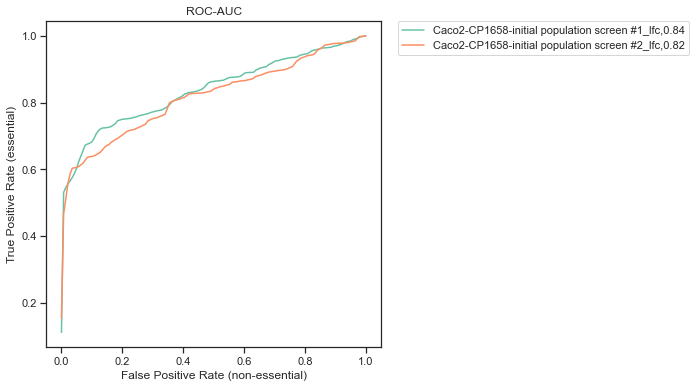

In [14]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [15]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Caco2-CP1658-initial population screen #1_lfc,Caco2-CP1658-resistant population screen #1_lfc,Caco2-CP1658-initial population screen #2_lfc,Caco2-CP1658-resistant population screen #2_lfc
0,AAAAAAAATCTTGCTCAGGG,-0.343054,-0.276066,0.231444,0.664241
1,AAAAAATCGAACCATCTGAA,-0.704628,-0.564386,0.131732,-0.726568
2,AAAAAGCACTACCGTACCAT,-0.652495,0.818433,-0.323622,-0.768024
3,AAAAATCCTCTGAAGCCGCA,-1.240382,-4.524159,0.062365,-2.089687
4,AAAAATTGTAGGGCGCACCA,-3.257074,-7.186363,-1.655263,-4.794892
...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,0.599482,1.052971,0.487952,0.494562
6278,TTTGTCCCTTCTTAAAAAAC,0.599482,1.052971,0.487952,0.494562
6279,TTTGTCGTGAAGATGCACAA,0.347953,0.584275,0.109408,0.293639
6280,TTTGTGCTCACCTACAAGCT,-0.081932,-0.133378,-0.024887,-1.029549


In [16]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                          modified  \
0  Caco2-CP1658-resistant population screen #1_lfc   
1  Caco2-CP1658-resistant population screen #2_lfc   

                                     unperturbed  
0  Caco2-CP1658-initial population screen #1_lfc  
1  Caco2-CP1658-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCTTGCTCAGGG,Caco2-CP1658-resistant population screen #1_lfc,0.540501,0.634926,Caco2-CP1658-initial population screen #1_lfc,-0.276066,-0.343054
1,AAAAAATCGAACCATCTGAA,Caco2-CP1658-resistant population screen #1_lfc,0.771887,0.906735,Caco2-CP1658-initial population screen #1_lfc,-0.564386,-0.704628
2,AAAAAGCACTACCGTACCAT,Caco2-CP1658-resistant population screen #1_lfc,2.080642,2.444129,Caco2-CP1658-initial population screen #1_lfc,0.818433,-0.652495
3,AAAAATCCTCTGAAGCCGCA,Caco2-CP1658-resistant population screen #1_lfc,-2.442975,-2.869762,Caco2-CP1658-initial population screen #1_lfc,-4.524159,-1.240382
4,AAAAATTGTAGGGCGCACCA,Caco2-CP1658-resistant population screen #1_lfc,-2.530549,-2.972634,Caco2-CP1658-initial population screen #1_lfc,-7.186363,-3.257074
...,...,...,...,...,...,...,...
12163,TTTGTCACTAAAGTGGACAA,Caco2-CP1658-resistant population screen #2_lfc,0.307454,0.419308,Caco2-CP1658-initial population screen #2_lfc,-0.888382,-0.550016
12164,TTTGTCCCTTCTTAAAAAAC,Caco2-CP1658-resistant population screen #2_lfc,-0.086580,-0.118078,Caco2-CP1658-initial population screen #2_lfc,0.494562,0.487952
12165,TTTGTCGTGAAGATGCACAA,Caco2-CP1658-resistant population screen #2_lfc,0.377403,0.514705,Caco2-CP1658-initial population screen #2_lfc,0.293639,0.109408
12166,TTTGTGCTCACCTACAAGCT,Caco2-CP1658-resistant population screen #2_lfc,-0.714453,-0.974376,Caco2-CP1658-initial population screen #2_lfc,-1.029549,-0.024887


In [17]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=10, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAATCTTGCTCAGGG,HYMAI
1,AAAAAATCGAACCATCTGAA,USP14
2,AAAAAGCACTACCGTACCAT,SLC26A7
3,AAAAATCCTCTGAAGCCGCA,TOP3A
4,AAAAATTGTAGGGCGCACCA,NCAPG
...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6
6279,TTTGTCGTGAAGATGCACAA,CREBBP
6280,TTTGTGCTCACCTACAAGCT,MFSD3


In [18]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Caco2-CP1658-resistant population screen #1_lfc,ACE2,10,0.677293,-1.735752,12.221295,2.392436e-34,1.619679e-31
1,Caco2-CP1658-resistant population screen #1_lfc,ACR,10,-0.242492,0.216242,-0.979113,3.275244e-01,7.416718e-01
2,Caco2-CP1658-resistant population screen #1_lfc,ACTR2,10,-4.369617,-2.685496,-1.827342,6.764840e-02,3.158481e-01
3,Caco2-CP1658-resistant population screen #1_lfc,ACTR3,10,-2.545560,-1.322689,-1.401422,1.610878e-01,5.281812e-01
4,Caco2-CP1658-resistant population screen #1_lfc,ADAM7,10,0.174750,0.123071,1.069088,2.850301e-01,7.120493e-01
...,...,...,...,...,...,...,...,...
1349,Caco2-CP1658-resistant population screen #2_lfc,ZNF572,10,0.378272,0.309640,0.468102,6.397118e-01,8.722663e-01
1350,Caco2-CP1658-resistant population screen #2_lfc,ZNF594,10,0.406409,0.191427,1.483073,1.380549e-01,4.506626e-01
1351,Caco2-CP1658-resistant population screen #2_lfc,ZNF7,10,-0.065493,0.197783,-0.597811,5.499660e-01,8.425015e-01
1352,Caco2-CP1658-resistant population screen #2_lfc,ZNF703,10,0.494141,0.441093,-0.051023,9.593074e-01,9.882347e-01


In [19]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 8, guide_max = 11)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Caco2-CP1658-resistant population screen #2_lfc', 'Caco2-CP1658-resistant population screen #1_lfc']
Caco2-CP1658-resistant population screen #2_lfc
Caco2-CP1658-resistant population screen #1_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCTTGCTCAGGG,HYMAI,Caco2-CP1658-resistant population screen #1_lfc,0.540501,0.634926,Caco2-CP1658-initial population screen #1_lfc,-0.276066,-0.343054
1,AAAAAAAATCTTGCTCAGGG,HYMAI,Caco2-CP1658-resistant population screen #2_lfc,0.535629,0.730494,Caco2-CP1658-initial population screen #2_lfc,0.664241,0.231444
2,AAAAAATCGAACCATCTGAA,USP14,Caco2-CP1658-resistant population screen #1_lfc,0.771887,0.906735,Caco2-CP1658-initial population screen #1_lfc,-0.564386,-0.704628
3,AAAAAATCGAACCATCTGAA,USP14,Caco2-CP1658-resistant population screen #2_lfc,-0.681505,-0.929441,Caco2-CP1658-initial population screen #2_lfc,-0.726568,0.131732
4,AAAAAGCACTACCGTACCAT,SLC26A7,Caco2-CP1658-resistant population screen #1_lfc,2.080642,2.444129,Caco2-CP1658-initial population screen #1_lfc,0.818433,-0.652495
...,...,...,...,...,...,...,...,...
12559,TTTGTCGTGAAGATGCACAA,CREBBP,Caco2-CP1658-resistant population screen #2_lfc,0.377403,0.514705,Caco2-CP1658-initial population screen #2_lfc,0.293639,0.109408
12560,TTTGTGCTCACCTACAAGCT,MFSD3,Caco2-CP1658-resistant population screen #1_lfc,0.298858,0.351069,Caco2-CP1658-initial population screen #1_lfc,-0.133378,-0.081932
12561,TTTGTGCTCACCTACAAGCT,MFSD3,Caco2-CP1658-resistant population screen #2_lfc,-0.714453,-0.974376,Caco2-CP1658-initial population screen #2_lfc,-1.029549,-0.024887
12562,TTTGTGTTGATGAATCCTGG,IL1R1,Caco2-CP1658-resistant population screen #1_lfc,0.045477,0.053421,Caco2-CP1658-initial population screen #1_lfc,-0.054684,0.139516


In [32]:
with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Caco2_Cas9SecondaryLibraryKO_Goujon.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Caco2_avg_zscore', index =False)
    reads_CP1658.to_excel(writer, sheet_name='Caco2_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Caco2_guide_mapping', index =False)

In [21]:
screen1_df = gene_residuals[gene_residuals['condition'].str.contains('#1')]
screen2_df = gene_residuals[gene_residuals['condition'].str.contains('#2')]
zscore_df = pd.merge(screen1_df[['Gene Symbol', 'residual_zscore']], screen2_df[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])
zscore_df

,Gene Symbol,residual_zscore_screen#1,residual_zscore_screen#2
0,ACE2,12.221295,13.336158
1,ACR,-0.979113,-0.708215
2,ACTR2,-1.827342,-1.695544
3,ACTR3,-1.401422,-0.809311
4,ADAM7,1.069088,0.597681
...,...,...,...
672,ZNF572,-0.285291,0.468102
673,ZNF594,1.454845,1.483073
674,ZNF7,-0.000662,-0.597811
675,ZNF703,-0.357504,-0.051023


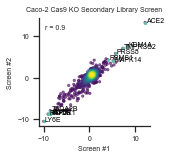

In [33]:
# Screen 2 vs Screen 1
fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', s=6)
ax = gpp.add_correlation(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', fontsize=7)

top_ranked_screen1 = zscore_df.nsmallest(10, 'residual_zscore_screen#1')
top_ranked_screen2 = zscore_df.nsmallest(10, 'residual_zscore_screen#2')
bottom_ranked_screen1 = zscore_df.nlargest(10, 'residual_zscore_screen#1')
bottom_ranked_screen2 = zscore_df.nlargest(10, 'residual_zscore_screen#2')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

# Annotate common hits
common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_screen#1', 'residual_zscore_screen#2'], how = 'inner')
common_ranked

sns.scatterplot(data=common_ranked, x='residual_zscore_screen#1', y='residual_zscore_screen#2', color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

texts= []
for j, row in common_ranked.iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1']+0.25, row['residual_zscore_screen#2'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Caco-2 Cas9 KO Secondary Library Screen', fontsize=7)
plt.xlabel('Screen #1', fontsize=7)
plt.ylabel('Screen #2', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
gpp.savefig('../../../Figures/Scatterplots/Caco2_Cas9KO_Secondary_Screen1vs2_scatterplot.pdf', dpi=300)



In [24]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Caco2_Cas9SecondaryLibraryKO_Goujon_indiv_screens.xlsx') as writer:  
    zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

## Primary vs Secondary Screen

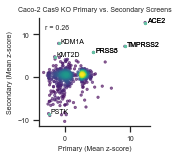

In [31]:
Caco2_primary = pd.read_excel('../../../Data/Processed/GEO_submission_v2/Caco2_Brunello_Goujon_v2.xlsx')

Caco2_primaryvssecondary = pd.merge(Caco2_primary, gene_residual_sheet, on = 'Gene Symbol', how = 'inner', suffixes=['_primary', '_secondary'])
Caco2_primaryvssecondary

fig, ax = plt.subplots(figsize=(2,2))
ax = gpp.point_densityplot(Caco2_primaryvssecondary, 'residual_zscore_avg_primary', 'residual_zscore_avg_secondary', s=6)
ax = gpp.add_correlation(Caco2_primaryvssecondary, 'residual_zscore_avg_primary', 'residual_zscore_avg_secondary', fontsize=7)

top_ranked_primary = Caco2_primaryvssecondary.nlargest(10, 'residual_zscore_avg_primary')
top_ranked_secondary = Caco2_primaryvssecondary.nlargest(10, 'residual_zscore_avg_secondary')
bottom_ranked_primary = Caco2_primaryvssecondary.nsmallest(10, 'residual_zscore_avg_primary')
bottom_ranked_secondary = Caco2_primaryvssecondary.nsmallest(10, 'residual_zscore_avg_secondary')

primary_ranked = pd.concat([top_ranked_primary, bottom_ranked_primary])
secondary_ranked = pd.concat([top_ranked_secondary, bottom_ranked_secondary])

# Annotate common hits
common_ranked = pd.merge(primary_ranked, secondary_ranked, on = ['Gene Symbol', 'residual_zscore_avg_primary', 'residual_zscore_avg_secondary'], how = 'inner')
common_ranked

annot_df = pd.concat([common_ranked, top_ranked_secondary.head(5)]).drop_duplicates()


sns.scatterplot(data=annot_df, x='residual_zscore_avg_primary', y='residual_zscore_avg_secondary', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

texts= []
for j, row in annot_df.iterrows():
    texts.append(ax.text(row['residual_zscore_avg_primary']+0.25, row['residual_zscore_avg_secondary'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Caco-2 Cas9 KO Primary vs. Secondary Screens', fontsize=7)
plt.xlabel('Primary (Mean z-score)', fontsize=7)
plt.ylabel('Secondary (Mean z-score)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()

gpp.savefig('../../../Figures/Scatterplots/Caco2_Cas9KO_PrimaryvsSecondary_scatterplot.pdf', dpi=300)

